In [2]:
%matplotlib inline
import os
import pprint
import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from EIANN._network import Network
import EIANN.utils as ut
import EIANN.plot as pt
pt.update_plot_defaults()

%load_ext autoreload
%autoreload 2

/Users/aaronmil/src/EIANN/EIANN/utils/data_utils.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Load MNIST data

In [3]:
# Load dataset
tensor_flatten = T.Compose([T.ToTensor(), T.Lambda(torch.flatten)])
MNIST_train_dataset = torchvision.datasets.MNIST(root='../data/mnist/datasets/MNIST_data/', train=True, download=True,
                                         transform=tensor_flatten)
MNIST_test_dataset = torchvision.datasets.MNIST(root='../data/mnist/datasets/MNIST_data/',
                                        train=False, download=True, transform=tensor_flatten)

# Add index to train & test data
MNIST_train = []
for idx,(data,target) in enumerate(MNIST_train_dataset):
    target = torch.eye(len(MNIST_train_dataset.classes))[target]
    MNIST_train.append((idx, data, target))
    
MNIST_test = []
for idx,(data,target) in enumerate(MNIST_test_dataset):
    target = torch.eye(len(MNIST_test_dataset.classes))[target]
    MNIST_test.append((idx, data, target))
    
# Put data in dataloader
data_generator = torch.Generator()
train_dataloader = torch.utils.data.DataLoader(MNIST_train[0:50000], shuffle=True, generator=data_generator)
val_dataloader = torch.utils.data.DataLoader(MNIST_train[-10000:], batch_size=10000, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(MNIST_test, batch_size=10000, shuffle=False)

In [4]:
def plot_mnist_network_intermediates(network, analyze_receptive_fields=None):
    if not ('H2E' in network.populations):
        return
    
    if hasattr(network.H2.E, 'plateau_history') and network.H2.E.plateau_history is not None:
        fig, axes = plt.subplots(4, 3, figsize=(10., 12.))

        binned_train_steps = network.val_history_train_steps
        xmin = binned_train_steps[0]
        xmax = binned_train_steps[-1] + 1
        ymax = 0
        
        ymin = network.H1.E.size
        im = axes[0][0].imshow(network.H1.E.plateau_history.T, aspect='auto', interpolation='none', extent=(xmin, xmax, ymin, ymax))
        plt.colorbar(im, ax=axes[0][0])
        axes[0][0].set_title('Plateau history: H1.E')
        axes[0][0].set_ylabel('Unit ID')
        axes[0][0].set_xlabel('Training steps')

        ymin = network.H2.E.size
        im = axes[0][1].imshow(network.H2.E.plateau_history.T, aspect='auto', interpolation='none', extent=(xmin, xmax, ymin, ymax))
        plt.colorbar(im, ax=axes[0][1])
        axes[0][1].set_title('Plateau history: H2.E')
        axes[0][1].set_ylabel('Unit ID')
        axes[0][1].set_xlabel('Training steps')

        ymin = network.Output.E.size
        im = axes[0][2].imshow(network.Output.E.plateau_history.T, aspect='auto', interpolation='none', extent=(xmin, xmax, ymin, ymax))
        plt.colorbar(im, ax=axes[0][2])
        axes[0][2].set_title('Plateau history: Output.E')
        axes[0][2].set_xlabel('Training steps')
        
        binned_Output_E_plateau_prob = network.Output.E.plateau_history.mean(dim=(1))
        binned_H1_E_plateau_prob = network.H1.E.plateau_history.mean(dim=(1))
        binned_H2_E_plateau_prob = network.H2.E.plateau_history.mean(dim=(1))
          
        axes[1][0].plot(binned_train_steps, binned_H1_E_plateau_prob)
        axes[1][1].plot(binned_train_steps, binned_H2_E_plateau_prob)
        axes[1][2].plot(binned_train_steps, binned_Output_E_plateau_prob)
        axes[1][0].set_ylabel('Mean plateau amp')
        axes[1][0].set_xlabel('Training steps')
        axes[1][1].set_xlabel('Training steps')
        axes[1][2].set_xlabel('Training steps')
        axes[1][0].set_title('Plateau_history: H1.E')
        axes[1][1].set_title('Plateau_history: H2.E')
        axes[1][2].set_title('Plateau_history: Output.E')
        
        binned_H1_E_forward_dend_state = network.H1.E.forward_dendritic_state_history.mean(dim=(1))
        binned_H1_E_backward_dend_state = network.H1.E.backward_dendritic_state_history.mean(dim=(1))
        
        axes[2][0].plot(binned_train_steps, binned_H1_E_forward_dend_state)
        axes[2][0].set_title('Forward dendritic state: H1.E')
        axes[2][0].set_xlabel('Training steps')
        axes[2][0].set_ylabel('Mean amplitude')
        
        axes[2][1].plot(binned_train_steps, binned_H1_E_backward_dend_state)
        axes[2][1].set_title('Backward dendritic state: H1.E')
        axes[2][1].set_xlabel('Training steps')
        
        binned_H2_E_forward_dend_state = network.H2.E.forward_dendritic_state_history.mean(dim=(1))
        binned_H2_E_backward_dend_state = network.H2.E.backward_dendritic_state_history.mean(dim=(1))
        
        axes[3][0].plot(binned_train_steps, binned_H2_E_forward_dend_state)
        axes[3][0].set_title('Forward dendritic state: H2.E')
        axes[3][0].set_xlabel('Training steps')
        axes[3][0].set_ylabel('Mean amplitude')
        
        axes[3][1].plot(binned_train_steps, binned_H2_E_backward_dend_state)
        axes[3][1].set_title('Backward dendritic state: H2.E')
        axes[3][1].set_xlabel('Training steps')
            
        fig.tight_layout()
        fig.show()
    
    if analyze_receptive_fields is not None:
        for population_name in analyze_receptive_fields:
            if population_name in network.populations:
                population = network.populations[population_name]
                receptive_fields = ut.compute_maxact_receptive_fields(population)
                if population is network.Output.E:
                    sort = False
                    num_rows = 1
                else:
                    sort = True
                    num_rows = 2
                pt.plot_receptive_fields(receptive_fields, sort=sort, num_cols=10, num_rows=num_rows, title=population_name)
                ut.compute_representation_metrics(population, test_dataloader, receptive_fields, plot=True)

## Build and train an EIANN model

In [5]:
## Create network object
# network_name = "20231129_EIANN_2_hidden_mnist_van_bp_relu_SGD_config_G_complete_optimized"                          # Feedforward ANN (Backprop)
# network_name = "20240419_EIANN_2_hidden_mnist_bpDale_relu_SGD_config_F_complete_optimized"                          # EIANN - Learned SomaI (Backprop)
# network_name = "20231129_EIANN_2_hidden_mnist_bpDale_relu_SGD_config_G_complete_optimized"                          # EIANN - Fixed SomaI (Backprop)
# network_name = "20241105_EIANN_2_hidden_mnist_Top_Layer_Supervised_Hebb_WeightNorm_config_7_complete_optimized"     # EIANN - Learned SomaI (Hebb, Top-Layer Supervised)
# network_name = "20241009_EIANN_2_hidden_mnist_BP_like_config_5J_complete_optimized"                                 # Dendritic Target Propagation (LDS, Top-down Weight Symmetry)
network_name = "20241120_EIANN_2_hidden_mnist_BP_like_config_5J_learn_TD_HTCWN_2_complete_optimized"                  # Dendritic Target Propagation (LDS, Learned Top-down weights)
# network_name = "20241212_EIANN_2_hidden_mnist_BTSP_config_5L_complete_optimized"                                    # Dendritic Target Propagation (BTSP, Top-down Weight Symmetry)
# network_name = "20241216_EIANN_2_hidden_mnist_BTSP_config_5L_learn_TD_HTCWN_3_complete_optimized"                   # Dendritic Target Propagation (BTSP, Learned Top-down weights)

# # Optional: Load network object from pickle file
# saved_network_path = f"../saved_networks/mnist/{network_name}.pkl"
# network = ut.load_network(saved_network_path)

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Samples:   0%|          | 0/2000 [00:00<?, ?it/s]

/Users/aaronmil/src/EIANN/EIANN/plot.py:213: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/aaronmil/src/EIANN/EIANN/plot.py:247: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


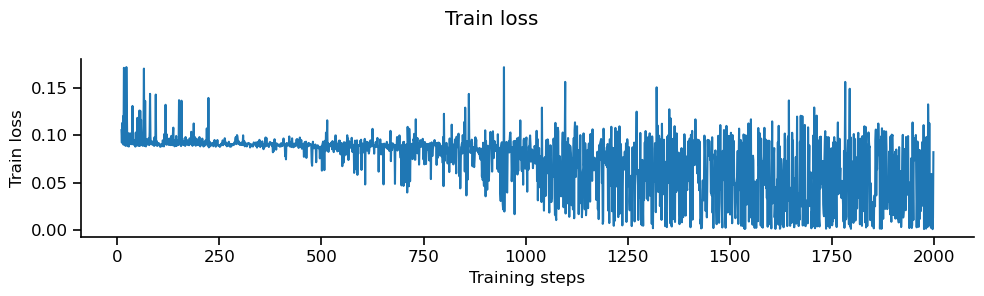

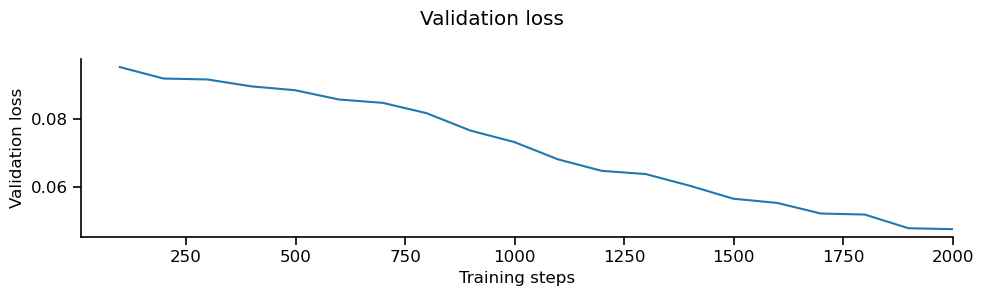

In [6]:
epochs = 1
data_seed = 257
network_seed = 66049
train_steps = 2000  # 20000
analyze_receptive_fields = None  # ['H2E']

# Create network object
config_file_path = f"../network_config/mnist/{network_name}.yaml"
network = ut.build_EIANN_from_config(config_file_path, network_seed=network_seed)

# Train network
data_generator.manual_seed(data_seed)
network.train(train_dataloader, val_dataloader, 
              samples_per_epoch=train_steps, 
              val_interval=(0, -1, 100), 
              store_history=True,
              store_history_interval=(0, -1, 100), 
              store_dynamics=False, 
              store_params=True,
              status_bar=True)

# # Optional: Save network object to pickle file
# saved_network_path = f"../saved_networks/mnist/{network_name}.pkl"
# ut.save_network(spiral_net, path=saved_network_path)

pt.plot_train_loss_history(network, train_step_range=(10, train_steps))
pt.plot_validate_loss_history(network, train_step_range=(10, train_steps))

# FFANN_bp_network = network
# EIANN_bp_learned_somaI_network = network
# EIANN_bp_fixed_somaI_network = network
# EIANN_hebb_network = network
DTP_LDS_network = network
# DTP_BTSP_network = network
# DTP_BTSP_TD_HTCWN_network = network

Batch accuracy = 65.18000030517578%


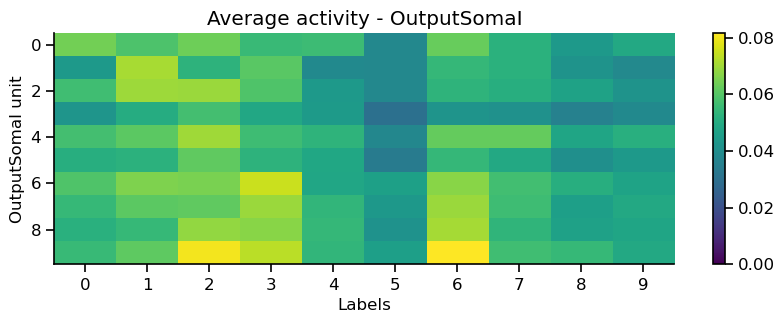

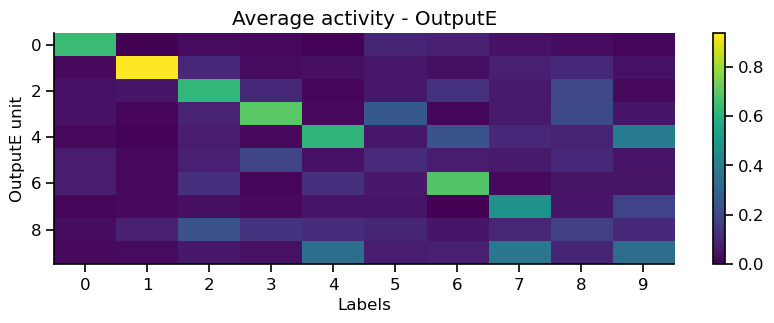

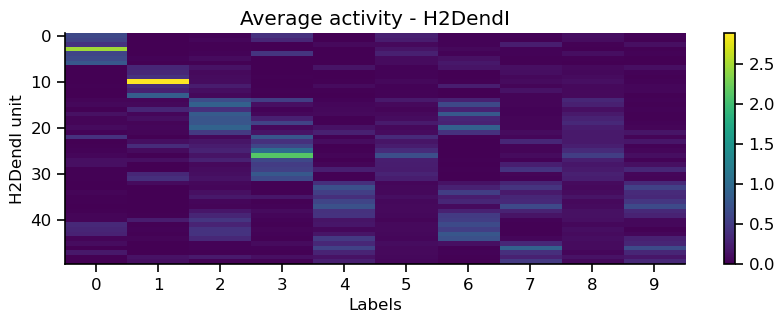

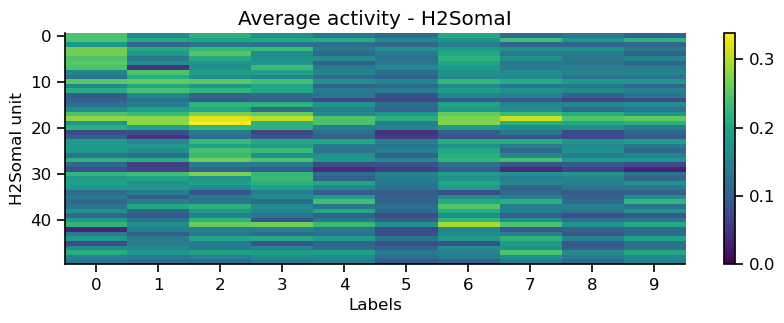

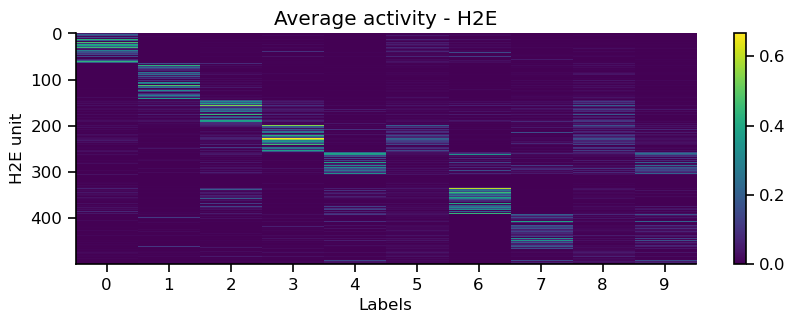

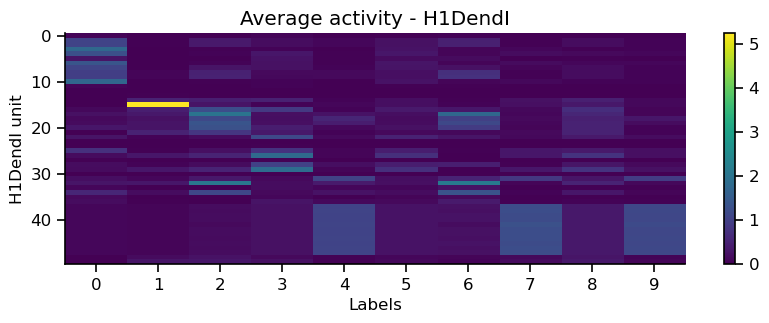

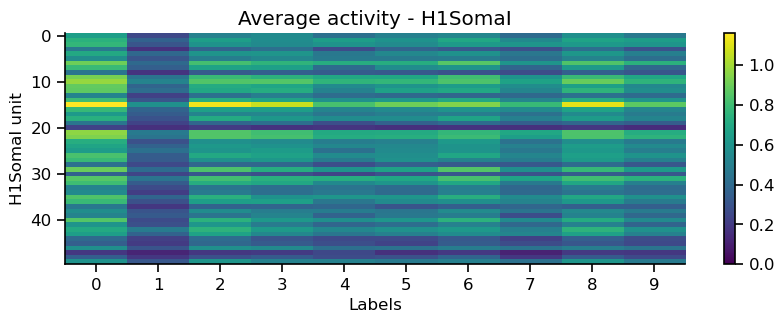

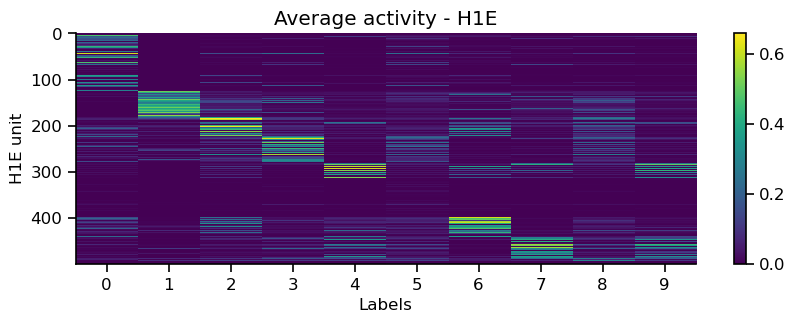

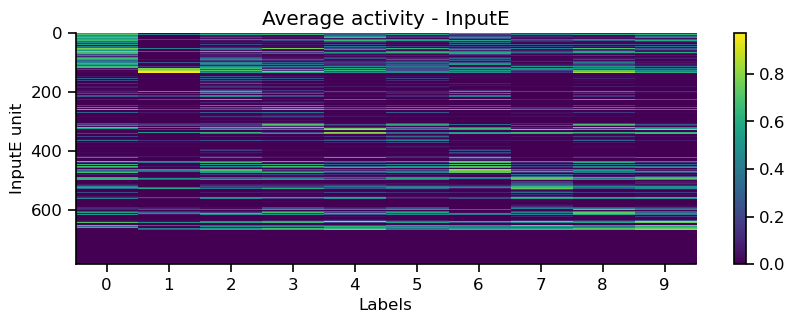

In [10]:
pt.plot_batch_accuracy(network, test_dataloader, title='', population='all')

/var/folders/q9/g15z8pxs2fd8tgyd9ggfv1c8x5w4qx/T/ipykernel_59703/2976782115.py:73: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


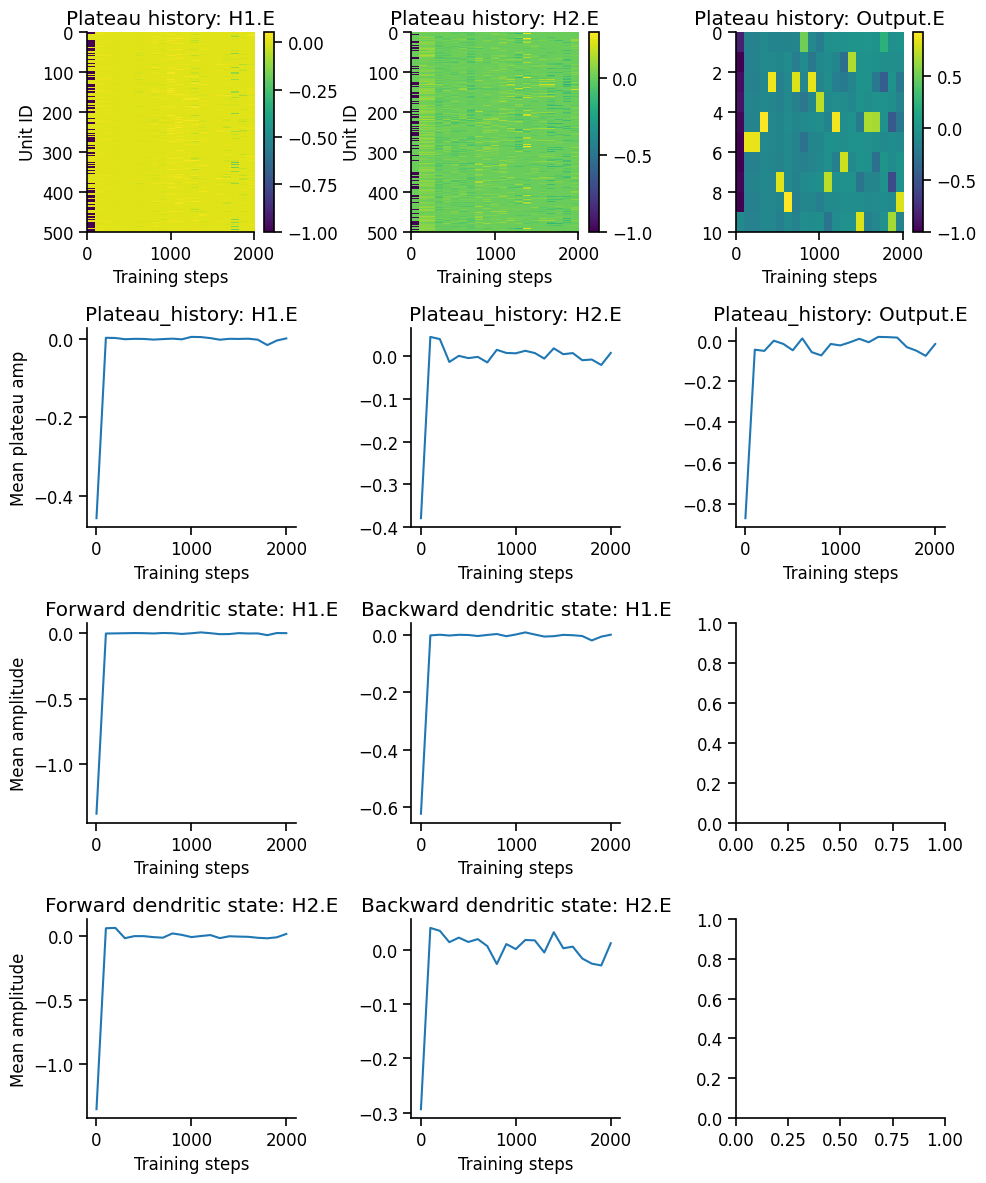

In [7]:
plot_mnist_network_intermediates(network, analyze_receptive_fields=analyze_receptive_fields)

  0%|          | 0/21 [00:00<?, ?it/s]

/Users/aaronmil/anaconda3/envs/py311/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 10])) that is different to the input size (torch.Size([10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Computing angles between actual and predicted parameter updates...


/Users/aaronmil/src/EIANN/EIANN/utils/representation_analysis.py:343: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


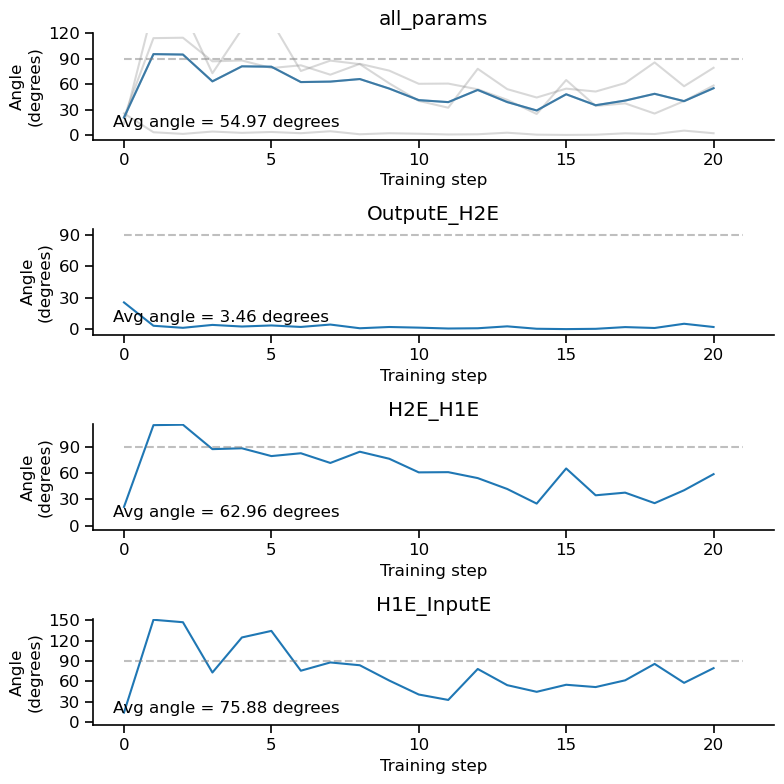

In [11]:
# Angle vs Backprop        
comparison_config_path = os.path.join(os.path.dirname(config_file_path), "20231129_EIANN_2_hidden_mnist_bpDale_relu_SGD_config_G_complete_optimized.yaml")
comparison_network = ut.build_EIANN_from_config(comparison_config_path, network_seed=network_seed)

# Compare angles for one train step (batch_size=1)
train_dataloader_onebatch = torch.utils.data.DataLoader(MNIST_train[0:50000], batch_size=50000, shuffle=False)
bpClone_network = ut.compute_alternate_dParam_history(train_dataloader_onebatch, network, comparison_network, batch_size=1)
angles = ut.compute_dW_angles_vs_BP(bpClone_network.predicted_dParam_history, bpClone_network.actual_dParam_history, plot=True)

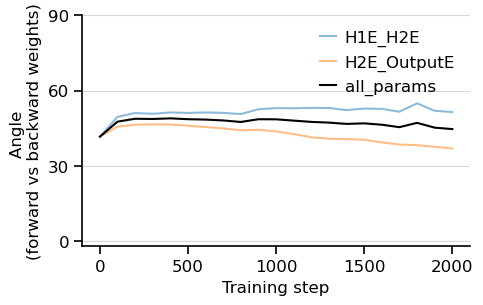

In [12]:
# Forward vs Backward weight angle (weight symmetry)
FF_FB_angles = ut.compute_feedback_weight_angle_history(network, plot=True)